# This file is used for exploring the data

In [1]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import hist
import math
import sqlite3

In [2]:
# Read in the data
courses = pd.read_csv('data/courses.csv')
assessments = pd.read_csv('data/assessments.csv')
vle = pd.read_csv('data/vle.csv')
students = pd.read_csv('data/studentInfo.csv')
student_registration = pd.read_csv('data/studentRegistration.csv')
student_assessments = pd.read_csv('data/studentAssessment.csv')
student_vle = pd.read_csv('data/studentVle.csv')

con = sqlite3.connect("data/ou.db")
cur = con.cursor()

In [39]:
test_assessments = student_assessments.copy(deep=True)

def add_time_before_deadline():
    global test_assessments
    joined_assessments = pd.merge(test_assessments, assessments, on='id_assessment')
    test_assessments['time_before_deadline'] = joined_assessments['date_submitted'] - joined_assessments['date']
    
def drop_banked():
    global test_assessments
    joined_assessments = pd.merge(test_assessments, assessments, on='id_assessment')
    test_assessments['is_banked'] = joined_assessments['is_banked']
    test_assessments = test_assessments[student_assessments.is_banked == 0]
    
def add_assessment_info():
    global test_assessments
    joined_assessments = pd.merge(test_assessments, assessments, on='id_assessment')
    test_assessments['weight'] = joined_assessments['weight']
    test_assessments['TMA'] = joined_assessments['assessment_type'] == "TMA"
    test_assessments['Exam'] = joined_assessments['assessment_type'] == "Exam"
    test_assessments['CMA'] = joined_assessments['assessment_type'] == "CMA"

def add_previous_average():
    global test_assessments
    # Use a sqlite database to make some calculations a lot quicker
    cur.execute('''
    SELECT (SELECT AVG(score)
        FROM assessments
                 JOIN student_assessments ON assessments.id_assessment = assessments.id_assessment AND
                                             student_assessments.id_student = sa.id_student
        WHERE date < a.date
          AND code_module = a.code_module
          AND assessments.code_presentation = a.code_presentation)
FROM assessments a
         JOIN student_assessments sa ON a.id_assessment = sa.id_assessment;
         ''')
    test_assessments['prev_avg'] = pd.DataFrame(cur.fetchall(), columns=['avg'])['avg']

    
# One hot encoding for assessment type
add_time_before_deadline()
drop_banked()
add_assessment_info()
add_previous_average()

test_assessments.head()

# total days worked on, total time worked on, last average


,id_assessment,id_student,date_submitted,is_banked,score,time_before_deadline,weight,TMA,Exam,CMA,prev_avg
0,1752,11391,18,0,78.0,-1.0,10.0,True,False,False,NaN
1,1752,28400,22,0,70.0,3.0,10.0,True,False,False,NaN
2,1752,31604,17,0,72.0,-2.0,10.0,True,False,False,NaN
3,1752,32885,26,0,69.0,7.0,10.0,True,False,False,NaN
4,1752,38053,19,0,79.0,0.0,10.0,True,False,False,NaN


114108


(array([6.200e+01, 1.000e+00, 4.000e+00, 7.000e+00, 7.000e+00, 1.000e+01,
        5.000e+00, 3.600e+01, 7.000e+00, 1.200e+01, 2.800e+01, 1.200e+01,
        3.500e+01, 1.400e+01, 6.800e+01, 5.900e+01, 2.600e+01, 3.500e+01,
        5.100e+01, 2.900e+01, 8.200e+01, 7.800e+01, 4.300e+01, 1.110e+02,
        4.400e+01, 1.230e+02, 4.800e+01, 8.600e+01, 4.130e+02, 6.000e+01,
        1.760e+02, 1.290e+02, 1.230e+02, 1.990e+02, 1.230e+02, 9.800e+01,
        3.900e+02, 1.610e+02, 3.650e+02, 2.390e+02, 2.930e+02, 4.730e+02,
        2.210e+02, 1.183e+03, 3.050e+02, 3.190e+02, 8.380e+02, 3.310e+02,
        9.160e+02, 3.950e+02, 7.210e+02, 9.070e+02, 5.050e+02, 5.310e+02,
        1.215e+03, 4.330e+02, 1.182e+03, 2.067e+03, 4.800e+02, 1.267e+03,
        6.170e+02, 1.346e+03, 5.030e+02, 6.470e+02, 1.214e+03, 3.810e+02,
        9.750e+02, 4.690e+02, 3.350e+02, 5.610e+02, 2.470e+02, 3.051e+03]),
 array([  0.        ,   1.38888889,   2.77777778,   4.16666667,
          5.55555556,   6.94444444,   8.333333

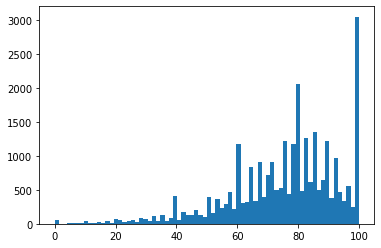

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

test_assessments = test_assessments.dropna()
X = test_assessments
X = X.drop(["id_assessment", "id_student", "is_banked", "score", "date_submitted"], axis=1)

y = test_assessments.score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(len(X_train))
hist(y_test, bins=72)

17.655982793372488
22.819640761567154


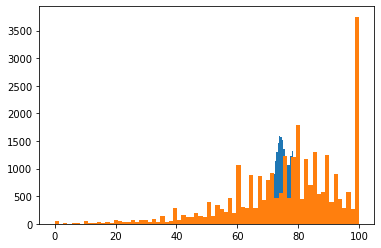

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

models = [
    LinearRegression(),
    RandomForestClassifier(random_state=0)
]

for model in models:
    model.fit(X_train, y_train)
    y_prediction = model.predict(X_test)
    print(math.sqrt(mean_squared_error(y_test, y_prediction)))
    hist(y_prediction, bins=72)